In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/dataframes.py
%pprint
%who

DATA_FOLDER: ../data/
SAVES_FOLDER: ../saves/
Pretty printing has been turned OFF
DATA_FOLDER	 ENCODING_TYPE	 SAVES_FOLDER	 attempt_to_pickle	 example_iterrows	 get_column_descriptions	 load_csv	 load_dataframes	 load_object	 
math	 os	 pd	 pickle	 save_dataframes	 store_objects	 


In [2]:

gun_stats_df = load_object('gun_stats_df')
gun_stats_df.columns

Index(['Ethnic_diversity_rank', 'Ethnic_fractionalization_index',
       'Cultural_diversity_index', 'Fractionalization_rank',
       'Ethnic_fractionalization', 'Linguistic_fractionalization',
       'Religious_fractionalization', 'Murder_rate', 'Murder_count', 'Region',
       'Subregion', 'Year_listed', 'UNODC_notes', 'Gun_rank',
       'Guns_per_100_residents', 'Karp_notes', 'Region_code', 'Subregion_code',
       'IQ_Rank', 'IQ'],
      dtype='object')

We will now proceed to:

1. Explore datasets with one variable and two conditions

2. Implement nonparametric alternatives to the t-test

3. Explore datasets with two variables and one condition
     
4. Compute the Pearson correlation coefficients

5. Establish the error of the estimate, using bootstrap.
 
6. Test hypotheses on the correlation between two variables, using
   bootstrap.
 
7. Use Montecarlo Methdos to test hypotheses.

In [3]:

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:

import numpy as np
from scipy import stats

def bootstrap(a, n_boot=10000, stat_func=np.mean):
    """Resample an array with replacement and calculate a summary stat.

    Parameters
    ----------
    a: array
        data to resample
    n_boot: int
        number of resamples
    stat_func: callable
        function to call on each resampled dataset

    """
    boot_dist = np.zeros(n_boot)
    n = len(a)
    for i in xrange(n_boot):
        sample = a[np.random.randint(0, n, n)]
        boot_dist[i] = stat_func(sample)
    return boot_dist


def percentiles(a, pcts):
    """Like scoreatpercentile but can take and return array of percentiles.

    Parameters
    ----------
    a: array
        data
    pcts: sequence of percentile values
        percentile or percentiles to find score at

    Returns
    -------
    scores: array
        array of scores at requested percentiles
    """
    try:
        scores = np.zeros(len(pcts))
    except TypeError:
        pcts = [pcts]
        scores = np.zeros(1)
    for i, p in enumerate(pcts):
        scores[i] = stats.scoreatpercentile(a, p)
    return scores


def pmf_hist(a, bins=10):
    """Return arguments to plt.bar for pmf-like histogram of an array.

    Parameters
    ----------
    a: array-like
        array to make histogram of
    bins: int
        number of bins

    Returns
    -------
    x: array
        left x position of bars
    h: array
        height of bars
    w: float
        width of bars

    """
    n, x = np.histogram(a, bins)
    h = n / n.sum()
    w = x[1] - x[0]
    return x[:-1], h, w

In [5]:

import seaborn
seaborn.set()
colors = seaborn.color_palette()

### (1) Exploring a complex dataset: one variable, two conditions

Motivation: 

   Samples from a population will show variation in their means. So, when
   drawing two samples from a single population, there is some chance
   that the samples will have different means, even though the underlying
   population is the same.

Suppose two samples are drawn from the same distribution. There were always
be some non-zero likelihood of obtaining a difference in the means of these
samples, although no difference should actually be there.

The following simulation shows that given a population and finite
sample size there will always be some probability of getting a difference
between two random samples.
   
Furthermore, we will show that the probability of getting large spurious
differences increases as the sample size decreases.


In [6]:

print(gun_stats_df['Region'].unique())
print(gun_stats_df['Subregion'].unique())

['Americas' 'Africa' 'Asia' 'Europe' 'Oceania']
['Caribbean' 'Central America' 'Eastern Africa' 'Western Asia'
 'Northern Africa' 'Eastern Asia' 'South America' 'Southern Europe'
 'Eastern Europe' 'Northern Europe' 'Southern Asia' 'Western Europe'
 'Southern Africa' 'South-Eastern Asia' 'Western Africa' 'Australasia'
 'Melanesia' 'Central Asia' 'Northern America' 'Middle Africa']


In [7]:

# Generate a population with mean 0 and sd of 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

white_series = (gun_stats_df['Region'] == 'Europe')
white_murder_data = gun_stats_df[white_series]['Murder_rate'].values.reshape(-1, 1)
scaler.fit(white_murder_data)
scaled_white_murder_data = scaler.transform(white_murder_data)
format_str = 'Generated a European population with mean {:0.1f} and sd of {:0.1f}'
print(format_str.format(scaled_white_murder_data.mean(), scaled_white_murder_data.std()))

black_series = (gun_stats_df['Region'] == 'Africa')
black_murder_data = gun_stats_df[black_series]['Murder_rate'].values.reshape(-1, 1)
scaler.fit(black_murder_data)
scaled_black_murder_data = scaler.transform(black_murder_data)
format_str = 'Generated an African population with mean {:0.1f} and sd of {:0.1f}'
print(format_str.format(scaled_black_murder_data.mean(), scaled_black_murder_data.std()))

hispanic_series = (gun_stats_df['Subregion'].isin(['Caribbean', 'Central America', 'South America']))
hispanic_murder_data = gun_stats_df[hispanic_series]['Murder_rate'].values.reshape(-1, 1)
scaler.fit(hispanic_murder_data)
scaled_hispanic_murder_data = scaler.transform(hispanic_murder_data)
format_str = 'Generated a Latino population with mean {:0.1f} and sd of {:0.1f}'
print(format_str.format(scaled_hispanic_murder_data.mean(), scaled_hispanic_murder_data.std()))

Generated a European population with mean -0.0 and sd of 1.0
Generated an African population with mean -0.0 and sd of 1.0
Generated a Latino population with mean -0.0 and sd of 1.0


A t-test is a statistical method to establish the likelihood of the
difference between the means of two samples drawn from an unknown
distribution. The shape of this distribution is assumed to be gaussian.

The null-hypothesis for this test is: The two sample come from the same
distribution. 

A t-test finds the probability that the two means were drawn from the
same distribution. If that probability is small we can reject the null
hypothesis and support the alternative hypothesis that the two samples
did not come from the same distribution. 

Here after we show how to use bootstrap to generate the equivalent of a
t-test.

In [24]:

from scipy.stats import ttest_ind

t, p = ttest_ind(white_murder_data, black_murder_data, equal_var=False)
print('European vs African: t={:0.2f}; p={:0.3f}'.format(t[0], p[0]))
t, p = ttest_ind(white_murder_data, hispanic_murder_data, equal_var=False)
print('European vs Hispanic: t={:0.2f}; p={:0.3f}'.format(t[0], p[0]))
t, p = ttest_ind(black_murder_data, hispanic_murder_data, equal_var=False)
print('African vs Hispanic: t={:0.2f}; p={:0.3f}'.format(t[0], p[0]))

European vs African: t=-5.24; p=0.000
European vs Hispanic: t=-4.08; p=0.001
African vs Hispanic: t=-2.90; p=0.008



During 2015–2016, the age-adjusted homicide rate for the total population increased from 5.7 to 6.2 per 100,000 standard population (an 8.8% increase). The rate increased from 2.6 to 2.9 (11.5%) for non-Hispanic whites, from 20.9 to 22.8 (9.1%) for non-Hispanic blacks, and from 4.9 to 5.3 (8.2%) for Hispanics. In both years, the homicide rate for non-Hispanic blacks was approximately eight times the rate for non-Hispanic whites and four times the rate for Hispanics.

In [63]:

from scipy.stats import ttest_ind

format_str = 'Here are the country groups tested against the murder rate data you agreed to:'
print(format_str)
print()

hypothesis_format_str = 'We {} reject the null hypothesis that the {} '
hypothesis_format_str += 'do not come from the same distribution as the {}.'

def test_populations(murder_data, us_data, country_str, test_race):
    t, p = ttest_ind(murder_data, us_data)
    print('{} vs {}: t={:0.2f}; p={:0.3f}'.format(country_str, test_race, t[0], p[0]))

    # If that probability is small we can reject the null hypothesis
    if p[0] < 0.05:
        can_cannot = 'can'
    else:
        can_cannot = 'cannot'
    print(hypothesis_format_str.format(can_cannot, test_race, country_str))
    print()

# The rate increased from 2.6 to 2.9 (11.5%) for non-Hispanic whites
test_race = 'US White, non-Hispanic'
us_white_data = np.array([[2.6], [2.9]])

country_str = 'European countries'
test_populations(white_murder_data, us_white_data, country_str, test_race)
country_str = 'Latin American countries'
test_populations(hispanic_murder_data, us_white_data, country_str, test_race)
country_str = 'African countries'
test_populations(black_murder_data, us_white_data, country_str, test_race)

# The rate increased from 4.9 to 5.3 (8.2%) for Hispanics
test_race = 'US Hispanic'
us_hispanic_data = np.array([[4.9], [5.3]])

country_str = 'European countries'
test_populations(white_murder_data, us_hispanic_data, country_str, test_race)
country_str = 'Latin American countries'
test_populations(hispanic_murder_data, us_hispanic_data, country_str, test_race)
country_str = 'African countries'
test_populations(black_murder_data, us_hispanic_data, country_str, test_race)

# The rate increased from 20.9 to 22.8 (9.1%) for non-Hispanic blacks
test_race = 'US Black, non-Hispanic'
us_black_data = np.array([[20.9], [22.8]])

country_str = 'European countries'
test_populations(white_murder_data, us_black_data, country_str, test_race)
country_str = 'Latin American countries'
test_populations(hispanic_murder_data, us_black_data, country_str, test_race)
country_str = 'African countries'
test_populations(black_murder_data, us_black_data, country_str, test_race)

Here are the country groups tested against the murder rate data you agreed to:

European countries vs US White, non-Hispanic: t=-1.12; p=0.271
We cannot reject the null hypothesis that the US White, non-Hispanic do not come from the same distribution as the European countries.

Latin American countries vs US White, non-Hispanic: t=1.15; p=0.264
We cannot reject the null hypothesis that the US White, non-Hispanic do not come from the same distribution as the Latin American countries.

African countries vs US White, non-Hispanic: t=0.94; p=0.353
We cannot reject the null hypothesis that the US White, non-Hispanic do not come from the same distribution as the African countries.

European countries vs US Hispanic: t=-3.56; p=0.001
We can reject the null hypothesis that the US Hispanic do not come from the same distribution as the European countries.

Latin American countries vs US Hispanic: t=1.02; p=0.320
We cannot reject the null hypothesis that the US Hispanic do not come from the same 

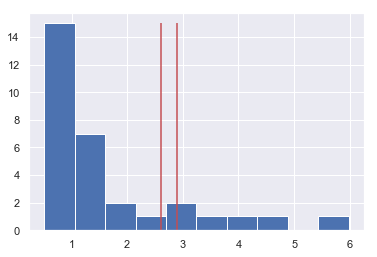

In [61]:

whites_AxesSubplot = gun_stats_df[white_series]['Murder_rate'].hist(bins=10)
whites_LineCollection = whites_AxesSubplot.vlines(us_white_data, 0, 15, colors='r',
                                                  label='US Whites')

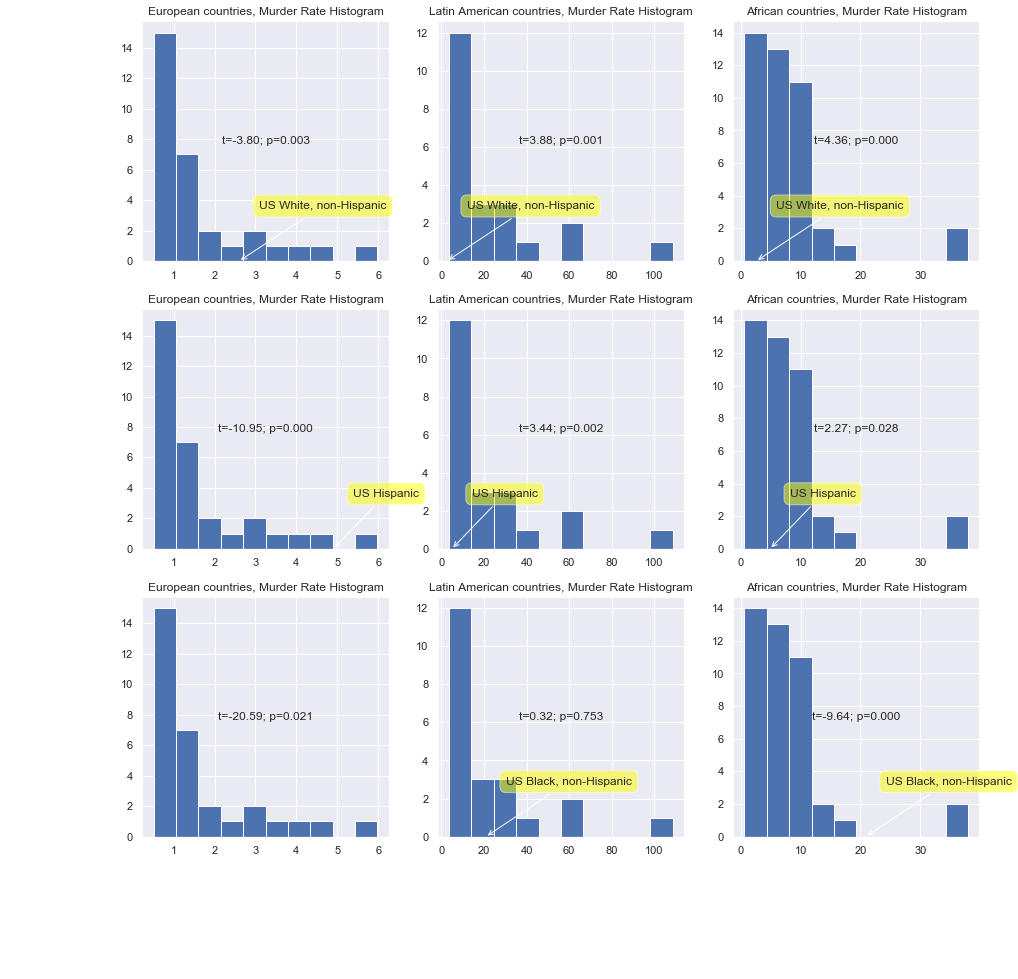

In [97]:

import matplotlib.pyplot as plt

def plot_populations(murder_series, us_murder_data, country_str, test_race, t, p, i):
    ax = fig.add_subplot(3, 3, i, autoscale_on=True)
    murders_AxesSubplot = gun_stats_df[murder_series]['Murder_rate'].hist(ax=ax, bins=10)
    kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    murders_annotation = plt.annotate(test_race, xy=(us_murder_data[0][0], 0), xytext=(20, 50),
                                     **kwargs)
    tp_str = 't={:0.2f}; p={:0.3f}'.format(t[0], p[0])
    plot_text = murders_AxesSubplot.text(0.5, 0.5, tp_str, horizontalalignment='center',
                                        verticalalignment='center',
                                        transform=murders_AxesSubplot.transAxes)
    title_str = '{}, Murder Rate Histogram'.format(country_str)
    title_text = murders_AxesSubplot.set_title(label=title_str)

fig = plt.figure(figsize=(15, 15))

# The rate increased from 2.6 to 2.9 (11.5%) for non-Hispanic whites
test_race = 'US White, non-Hispanic'
us_white_data = np.array([[2.6], [2.9]])

country_str = 'European countries'
t, p = ttest_ind(white_murder_data, us_white_data, equal_var=False)
plot_populations(white_series, us_white_data, country_str, test_race, t, p, 1)
country_str = 'Latin American countries'
t, p = ttest_ind(hispanic_murder_data, us_white_data, equal_var=False)
plot_populations(hispanic_series, us_white_data, country_str, test_race, t, p, 2)
country_str = 'African countries'
t, p = ttest_ind(black_murder_data, us_white_data, equal_var=False)
plot_populations(black_series, us_white_data, country_str, test_race, t, p, 3)

# The rate increased from 4.9 to 5.3 (8.2%) for Hispanics
test_race = 'US Hispanic'
us_hispanic_data = np.array([[4.9], [5.3]])

country_str = 'European countries'
t, p = ttest_ind(white_murder_data, us_hispanic_data, equal_var=False)
plot_populations(white_series, us_hispanic_data, country_str, test_race, t, p, 4)
country_str = 'Latin American countries'
t, p = ttest_ind(hispanic_murder_data, us_hispanic_data, equal_var=False)
plot_populations(hispanic_series, us_hispanic_data, country_str, test_race, t, p, 5)
country_str = 'African countries'
t, p = ttest_ind(black_murder_data, us_hispanic_data, equal_var=False)
plot_populations(black_series, us_hispanic_data, country_str, test_race, t, p, 6)

# The rate increased from 20.9 to 22.8 (9.1%) for non-Hispanic blacks
test_race = 'US Black, non-Hispanic'
us_black_data = np.array([[20.9], [22.8]])

country_str = 'European countries'
t, p = ttest_ind(white_murder_data, us_black_data, equal_var=False)
plot_populations(white_series, us_black_data, country_str, test_race, t, p, 7)
country_str = 'Latin American countries'
t, p = ttest_ind(hispanic_murder_data, us_black_data, equal_var=False)
plot_populations(hispanic_series, us_black_data, country_str, test_race, t, p, 8)
country_str = 'African countries'
t, p = ttest_ind(black_murder_data, us_black_data, equal_var=False)
plot_populations(black_series, us_black_data, country_str, test_race, t, p, 9)

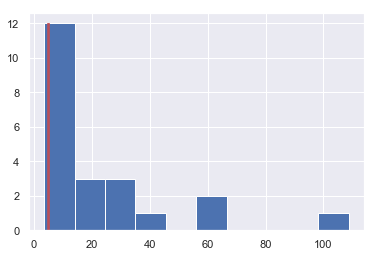

In [76]:

hispanics_AxesSubplot = gun_stats_df[hispanic_series]['Murder_rate'].hist(bins=10)
hispanics_LineCollection = hispanics_AxesSubplot.vlines(us_hispanic_data, 0, 12, colors='r',
                                                        label='US Hispanics')

In [80]:

hispanics_AxesSubplot.annotate?

### (3) Exploring a more complex dataset: two variables, one condition

Hereafter, we show an example of a slightly more complex data set.

So suppose we have one condition and measure not just one quantity (which
was the subject of Lecture 1) but measure two distinct quantities. For
example, suppose we measure both the heights and weights of male adults.

What can we do with the data? 

Let's generate two samples rapresenting two variables drawn from gaussian
distributions. The two variables are correlated with eachother.

In [19]:
n = 100
w = 0.6
s1 = randn(n)
s2 = w * s1 + (1 - w) * randn(n)

### (4) Correlation

We can quantify how correlated two variables are by using the metric
'correlation.'

Correlation values lie in the range -1 to 1, where -1 indicates a perfect
negative linear relationship, 0 indicates no relationship, and 1
indicates a perfect positive linear relationship. (Note that we
will use Pearson's product-moment correlation, but there are other variants of
correlation.)

Pearson's r is defined as

$$r = \frac{1}{n}\sum ^n _{i=1}\left[\left(\frac{X_i - \bar{X}}{s_X}\right)\left(\frac{Y_i - \bar{Y}}{s_Y}\right)\right]$$

In other words, we z-score each variable and then compute the average product of the variables.

In Python, we can compute this in a variety of ways:

In [20]:
# First there's the longwinded arithmetic
# (Note this isn't all that longwinded since it's a vectorized calculationg)
r1 = mean(((s1 - s1.mean()) / s1.std()) * ((s2 - s2.mean()) / s2.std()))

# We can also use functions from the scipy.stats package
from scipy import stats
r2 = mean(stats.zscore(s1) * stats.zscore(s2))

# This package even offers a one-step function
# Note this returns a tuple (r, p)
r3, p3 = stats.pearsonr(s1, s2)

print "%.3f, %.3f, %.3f" % (r1, r2, r3)

0.823, 0.823, 0.823


We can also visualize the relationship with a scatterplot

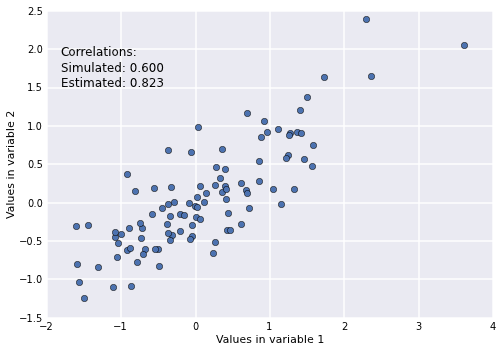

In [29]:
# Note that scatter(s1, s2) is equivalent to plot(s1, s2, "o")
plot(s1, s2, "o")
xlabel("Values in variable 1")
ylabel("Values in variable 2")

# We can display the simulated and computed correlations
annot = "Correlations:\nSimulated: %.3f\nEstimated: %.3f" % (w, r1)
text(xlim()[0] + .2, ylim()[1] - 1, annot, size=12);

### (5) Error bars

- How do we obtain error bars on the correlation observed in a set of data?

- How do we test whether the correlation observed in a set of data is
  significantly different from zero? 

Hereafter, we compute errorbars on the correlation coefficient using
bootstrap.

We compute k bootstrap (resampling with replacement) with the same size
of the original samples. 

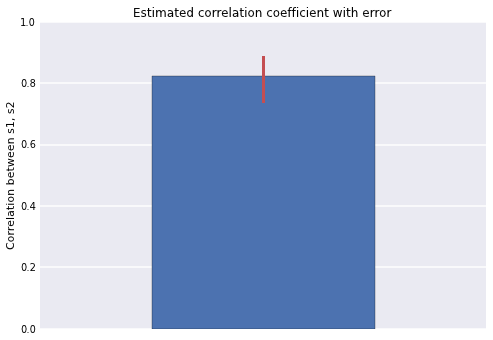

In [22]:
# Number of samples
k = 1000
r_dist = zeros(k)

# Do the bootstrap
for i in xrange(k):
    idx = randint(0, n, n)
    r_dist[i] = stats.pearsonr(s1[idx], s2[idx])[0]

# Compute the two-tailed 95% confidence intervals
ci = utils.percentiles(r_dist, [2.5, 97.5])

# Plot the correlation with error bars
bar(0.5, r1, width=1)
plot([1, 1], ci, color=colors[2], linewidth=3)
xlim(0, 2)
ylim(0, 1)
xticks(())
title("Estimated correlation coefficient with error")
ylabel("Correlation between s1, s2");

### (6) Test hypotheses

Now we want to test the hypothesis that the correlation r, was not
obtained by chance. We want to find the probability for the null
hypothesis to be true.

If the null hypothesis were true, we would be able to shuffle the
order of each variable and obtain datasets that are equivalent to the
original dataset. So, to obtain a p-value, we shuffle each variable,
calculate a correlation value for each shuffled sample. We repeat this
process a large number of times and count the number of times that
randomly obtained correlation values are more extreme than the actual
observed correlation value.

We create a bootstrap distribution of samples under the null hypothess
that s1 and s2 were not correlated.

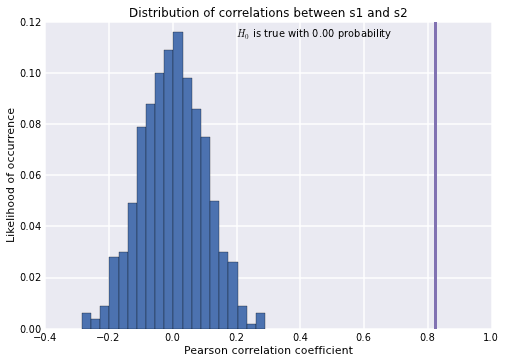

In [23]:
k = 1000
r_dist = zeros(k)
for i in xrange(k):
    s1_rand = s1[randint(0, n, n)]
    s2_rand = s2[randint(0, n, n)]
    r_dist[i] = stats.pearsonr(s1_rand, s2_rand)[0]

bar(*utils.pmf_hist(r_dist, 20))
title('Distribution of correlations between s1 and s2')
ylabel('Likelihood of occurrence')
xlabel('Pearson correlation coefficient')

# Now plot the empirical correlation value
axvline(r1, color=colors[3], linewidth=3)
p = sum(abs(r1) < abs(r_dist)) / k
text(0.2, ylim()[1] * .95, "$H_0$ is true with %.2f probability" % p);

### (7) Monte Carlo Methods

While we are on the topic of p-values on correlation values, it is
convenient to introduce here Monte Carlo methods. Monte Carlo methods are
a very general class of methods that make use of randomly generated data
to test various hypotheses. 

Monte Carlo methods are a very general class of methods that make use of
randomly generated data to test various hypotheses.
 
Imagine that we have obtained a correlation of r = 0.4 for a sample size
of 10. We do not know the population or any other information.

But we can assume that the true populations generating the two variables
were normally distributed. We can then simulate a process in
which we draw samples of size 10 from two independent Gaussian
distributions and compute the correlation value observed in each sample.
 
Such (Monte Carlo) simulations reveal that it is actually quite likely to
obtain a correlation of r = 0.4 for a sample size of 10, even when the
underlying distributions are independent. Thus, we should not believe the
claim.

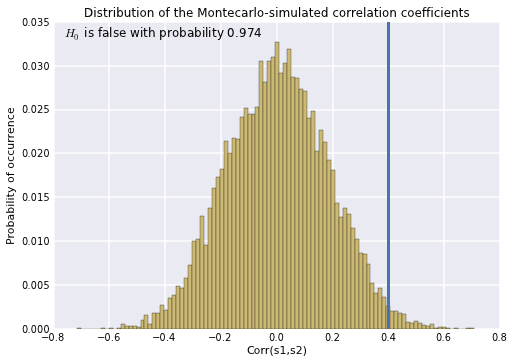

In [24]:
# Say our acutal measured correlation was 0.4
r_empirical = 0.4

# Simulate two IID normal variables
k = 10000 # number of sims
n = 30 # sample size
s1_sim = randn(k, n)
s2_sim = randn(k, n)

# Compute the correlation coefficient for each sample
r_dist = array(map(stats.pearsonr, s1_sim, s2_sim))[:, 0] # Take first column (r values)

# Plot the distribution of coefficients obtained this way
bar(*utils.pmf_hist(r_dist, 100), color=colors[4])
title('Distribution of the Montecarlo-simulated correlation coefficients')
ylabel('Probability of occurrence')
xlabel('Corr(s1,s2)')

# Plot the observed correlation on this PMF
axvline(r_empirical, color=colors[0], linewidth=3)

# Obtain the probability of our observed value by counting how many
# r's from our randomization test were more extreme
p = sum(abs(r_empirical) > abs(r_dist)) / k
xpos = xlim()[0] * .95
ypos = ylim()[1] * .95
text(xpos, ypos, "$H_0$ is false with probability %.3f" % p, size=12);